# M6A Analysis part3

This part of analysis will further fine-tune the m6A peaks across different replicates on the same condition, to faciliate furth downstream functional analysis.

Specifically, we will count the frequency of peaks in different replicates, and obtain a set of high-confidence peaks for each condition first. Then annotate these peaks by their corresponding gene, genomic region.

In [1]:
## A few global variables
%matplotlib inline
PEAK_DIR = "../_data/m6A/clam/"
MIN_OCCURRENCE_CUTOFF = 2

In [2]:
## read in folder files and use sample names to 
## determine the sample-groups
import os
from collections import defaultdict
peaks_fn_list = [x for x in os.listdir(PEAK_DIR) if x.startswith('peaks')]
replicate_group_dict = defaultdict(list)
for peak in peaks_fn_list:
    sam_group = '_'.join(peak.split('-')[1].split('_')[:-2])
    replicate_group_dict[sam_group].append(peak)

## merge F_KI and M_KI as Adult Kidney
replicate_group_dict['KI'] = replicate_group_dict['F_KI'] + replicate_group_dict['M_KI']
del replicate_group_dict['F_KI']
del replicate_group_dict['M_KI']

## show the result
#replicate_group_dict

## Import Intersection function and get table for each condition

You can find the source code in "scripts/count_peak.py"

In [3]:
from scripts.count_peak import *
help(intersect_peaks)

Help on function intersect_peaks in module scripts.count_peak:

intersect_peaks(replicate_list, peak_dir)
    function:: intersect_peaks(replicate_list, peak_dir)
    Intersect peaks for a group of replicates in the same condition.
    :param replicate_list: a list of filepaths replicates
    :param peak_dir: str, directory to all CLAM peaks, usually the 
      "project/clam" folder in `CLAM_eCLIP_Snakemake`
    :rtype: a Pandas DataFrame, with each row being peaks
    .. example::
        An example peak(row) will be like this:
        gene                   ENSMUSG00000019966
        strand                                  +
        replicate         F_KI_10,F_KI_09,F_KI_06
        ratio                      2.75,2.73,2.80
        num_replicates                          3
        Name: chr10:100096030-100096130:+, dtype: object



In [4]:
# read in all peaks in organized tables, and write to disk
df_dict = {}
for group in replicate_group_dict:
    df_dict[group] = intersect_peaks(replicate_group_dict[group], PEAK_DIR)
    #df_dict[group].to_csv("{}.peaks.tsv".format(group), sep="\t")

Because there are false positive peaks caused by peak calling uncertainties as well as random antibody binding, we need to find a proper cutoff for peak definition among different replicates

First plot the frequency histogram for different groups:

dict_keys(['P1_NKI', 'NH', 'RV', 'LV', 'KI'])


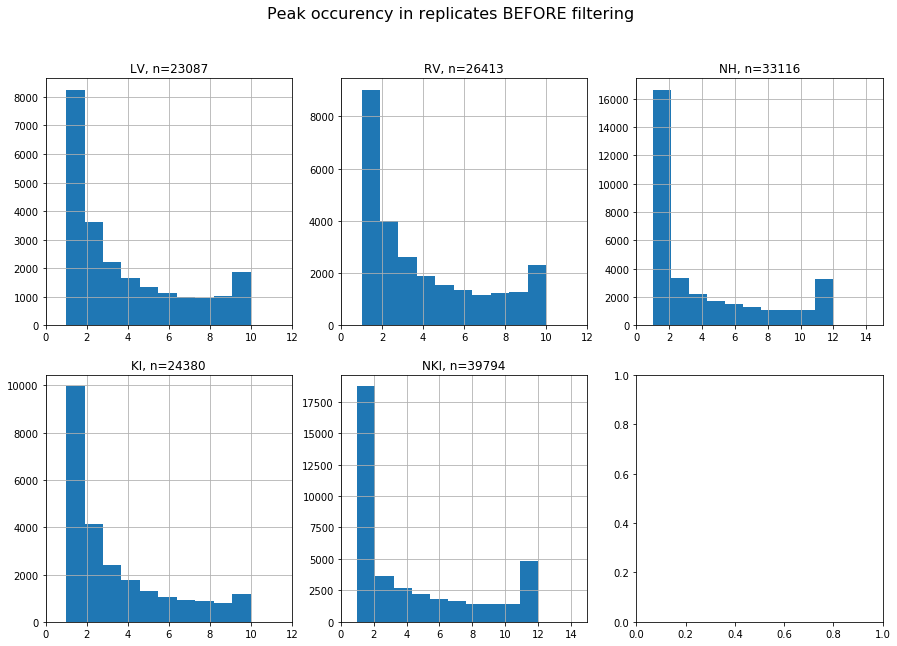

In [5]:
import matplotlib.pyplot as plt
print(df_dict.keys())
fig, axes = plt.subplots(2, 3, figsize=(15,10))
df_dict['LV'].num_replicates.hist(ax=axes[0][0])
axes[0,0].set_title('LV, n={}'.format(df_dict['LV'].shape[0]))
axes[0,0].set_xlim(0,12)
df_dict['RV'].num_replicates.hist(ax=axes[0][1])
axes[0,1].set_title('RV, n={}'.format(df_dict['RV'].shape[0]))
axes[0,1].set_xlim(0,12)
df_dict['NH'].num_replicates.hist(ax=axes[0][2])
axes[0,2].set_title('NH, n={}'.format(df_dict['NH'].shape[0]))
axes[0,2].set_xlim(0,15)
df_dict['KI'].num_replicates.hist(ax=axes[1][0])
axes[1,0].set_title('KI, n={}'.format(df_dict['KI'].shape[0]))
axes[1,0].set_xlim(0,12)
df_dict['P1_NKI'].num_replicates.hist(ax=axes[1][1])
axes[1,1].set_title('NKI, n={}'.format(df_dict['P1_NKI'].shape[0]))
axes[1,1].set_xlim(0,15)
fig.suptitle("Peak occurency in replicates BEFORE filtering", fontsize=16)
plt.show()

## Filtering out peaks

For some reason, the above histogram distribution for peak occurences over replicates is fairly similar to a (reversed) typical p-value distribution generated Null hypothesis testing. 

The underlying data mixture is also similar: p-value (peak occurence histogram) is a mixture of 
 - null hypothesis that distributes uniformly (true antibody IP event) 
 - alternative hypothesis that skews on one extreme (bogus antibody IP event)

As an ad hoc filter, we only keep the peaks that occurred >= 2 replicates, then write to disk.
Note: the cutoff was defined in the header by `MIN_OCCURRENCE_CUTOFF` variable.

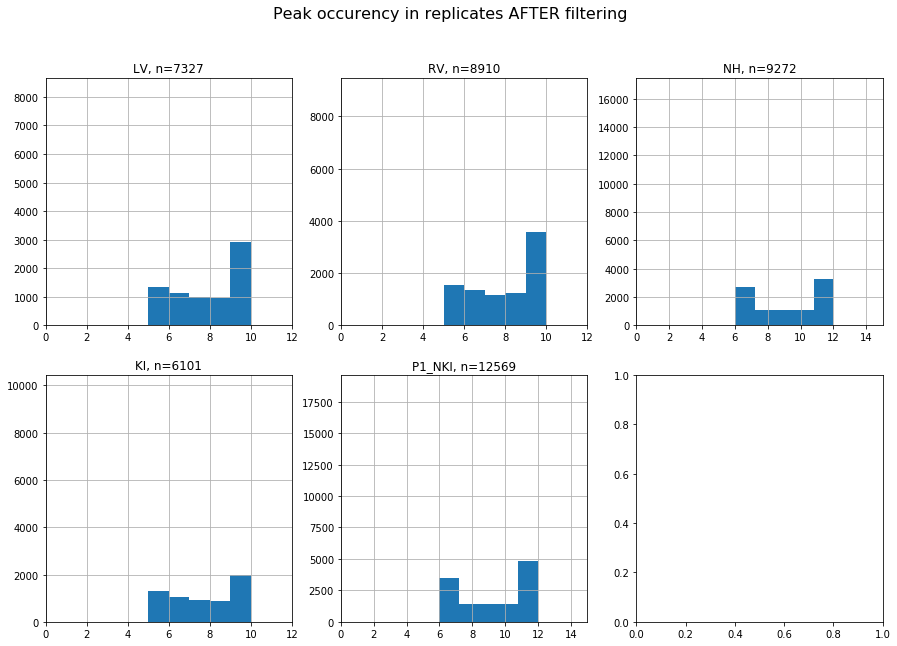

In [7]:
#MIN_OCCURRENCE_CUTOFF=2
min_occurrence_dict = {'LV':5, 'RV':5, 'NH':6, 'KI':5, 'P1_NKI':6}
def write_bed_out(df, outfn):
    with open(outfn, 'w') as f:
        for peak in df.index:
            chrom, start_end, strand = peak.split(":")
            start, end = start_end.split('-')
            f.write("{}\t{}\t{}\t.\t.\t{}\n".format(chrom, start, end, strand))
#print("Keeping >= {} peaks..".format(MIN_OCCURRENCE_CUTOFF))
filtered_group_dict = {}
fig2, axes2 = plt.subplots(2, 3, figsize=(15,10))
i=0; j=0
for group in ['LV', 'RV', 'NH', 'KI', 'P1_NKI']:
    #this = df_dict[group].loc[df_dict[group].num_replicates >= MIN_OCCURRENCE_CUTOFF ]
    # required >= 50% replicates
    this = df_dict[group].loc[df_dict[group].num_replicates >= min_occurrence_dict[group] ]
    this.to_csv("_data/{}.peaks.tsv".format(group), sep="\t")
    write_bed_out(this, "../_data/m6A/high_conf_peaks/{}.peaks.bed".format(group))
    this.num_replicates.hist(ax=axes2[i,j], bins=5)
    axes2[i,j].set_title("{}, n={}".format(group, this.shape[0]))
    axes2[i,j].set_xlim(axes[i,j].get_xlim())
    axes2[i,j].set_ylim(axes[i,j].get_ylim())
    filtered_group_dict[group] = this
    j += 1
    if j>2:
        j=0
        i += 1
fig2.suptitle("Peak occurency in replicates AFTER filtering", fontsize=16)
plt.show()

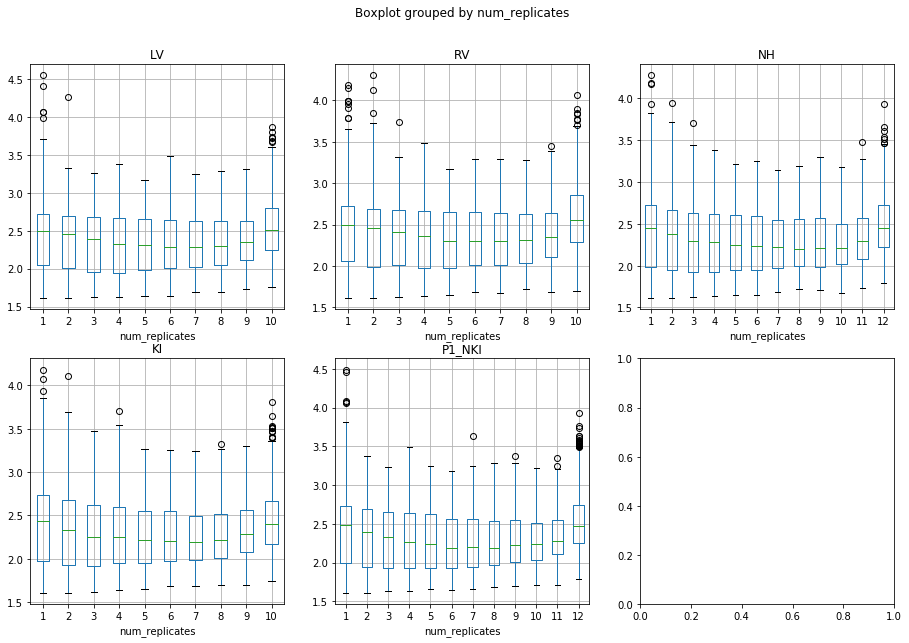

In [12]:
import numpy as np
fig3, axes3 = plt.subplots(2, 3, figsize=(15,10))
i=0; j=0
for group in ['LV', 'RV', 'NH', 'KI', 'P1_NKI']:
    df_dict[group]['avg_fc'] = df_dict[group]['ratio'].apply(lambda x: np.mean([float(_) for _ in x.split(',')]))
    #df_dict[group].plot.scatter(x='num_replicates', y='avg_fc', ax=axes3[i,j])
    df_dict[group].boxplot(by='num_replicates', column='avg_fc', ax=axes3[i,j])
    axes3[i,j].set_title(group)
    j += 1
    if j>2:
        j=0
        i += 1

## Write an Excel [Optional]

This will use `xlsxwriter` engine from `pandas`. Turns out writing to Excel using the `Pandas.ExcelWriter` interface is very straightforward 

In [7]:
WRITE_EXCEL = True
GENOME = 'mm10'
if(WRITE_EXCEL):
    import pandas as pd
    # read in Gene to GeneSymbol relationships
    # this part could use some clean-ups
    t2g = pd.read_table('../_data/t2g/t2g_{}.txt'.format(GENOME))
    g2s = {}
    for i in range(t2g.shape[0]):
        g2s[t2g.ensembl_gene_id[i]] = t2g.external_gene_name[i]
    url_formatter = '=HYPERLINK("https://genome.ucsc.edu/cgi-bin/hgTracks?db={genome}&position={locus}", "{locus}")'
    writer = pd.ExcelWriter('M6A_Peaks.xlsx', engine='xlsxwriter')
    for group in filtered_group_dict:
        filtered_group_dict[group] = filtered_group_dict[group].assign(url=pd.Series([ url_formatter.format(genome=GENOME, locus=x[:-2]) for x in filtered_group_dict[group].index ], index=filtered_group_dict[group].index).values)
        filtered_group_dict[group]['geneSymbol'] = filtered_group_dict[group].apply(lambda x: g2s[x.gene] if x.gene in g2s else '#NA', axis=1)
        filtered_group_dict[group].to_excel(writer, sheet_name=group)
    writer.save()

## Analysis of High-confidence peaks

1. get the topological distribution of high-conf peaks.
2. run HOMER to get the motif enrichment results.

Note: this is run on hoffman2 under folder `/u/home/f/frankwoe/nobackup/m6A_LowInput/high_conf_peaks`

For the run.sh, just a wrapper for calling topology and HOMER grapped from the Snakemake pipeline.

As an example, we show the topology and motif results for Neonatal Heart below:

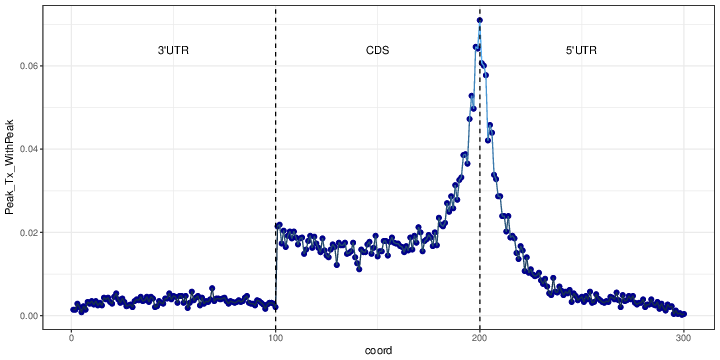

In [9]:
from wand.image import Image as WImage
topology_img = WImage(filename='./_data/plots/NH/topological_dist/dist.pdf')
topology_img

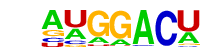

In [10]:
from wand.image import Image as WImage
motif_img = WImage(filename='./_data/plots/NH/homer/homerResults/motif1.logo.pdf')
motif_img

## Venn diagram for methylated genes

In this section we will use the R magic in ipython notebook, and also import the Pandas.DataFrame from python to R. To do so, first run the cell below:

In [9]:
%load_ext rpy2.ipython
NH = filtered_group_dict['NH']
LV = filtered_group_dict['LV']
RV = filtered_group_dict['RV']
NK = filtered_group_dict['P1_NKI']
AK = filtered_group_dict['KI']
%R -i NH -i LV -i RV -i NK -i AK

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


We also want to use this set of genes to perform a GO enrichment test.

In [26]:
import pandas as pd
t2g = pd.read_table('../_data/t2g/t2g_{}.txt'.format('mm10'))
g2s = {}
for i in range(t2g.shape[0]):
    g2s[t2g.ensembl_gene_id[i]] = t2g.external_gene_name[i]
NH.head()
NH_genes = set([g2s[x] for x in NH['gene'] if x in g2s])
AH_genes = set([g2s[x] for x in LV['gene'] if x in g2s]+[g2s[x] for x in RV['gene'] if x in g2s])
NK_genes = set([g2s[x] for x in NK['gene'] if x in g2s])
AK_genes = set([g2s[x] for x in AK['gene'] if x in g2s])
print(len(AH_genes))

6400


In [27]:
def writeFile(data, fn):
    with open(fn, 'w') as f:
        f.write('\n'.join(list(data)))

writeFile( NH_genes.difference(AH_genes), '../20181101-m6A-5/_data/mGene.NH_uniq.txt' )
writeFile( AH_genes.difference(NH_genes), '../20181101-m6A-5/_data/mGene.AH_uniq.txt' )
writeFile( AH_genes.intersection(NH_genes), '../20181101-m6A-5/_data/mGene.NHAH_common.txt' )
writeFile( AH_genes.union(NH_genes), '../20181101-m6A-5/_data/mGene.NHAH_background.txt' )

writeFile( NK_genes.difference(AK_genes), '../20181101-m6A-5/_data/mGene.NK_uniq.txt' )
writeFile( AK_genes.difference(NK_genes), '../20181101-m6A-5/_data/mGene.AK_uniq.txt' )
writeFile( AK_genes.intersection(NK_genes), '../20181101-m6A-5/_data/mGene.NKAK_common.txt' )
writeFile( AK_genes.union(NK_genes), '../20181101-m6A-5/_data/mGene.NKAK_background.txt' )

Now plot the Venns in R:

png 
  2 


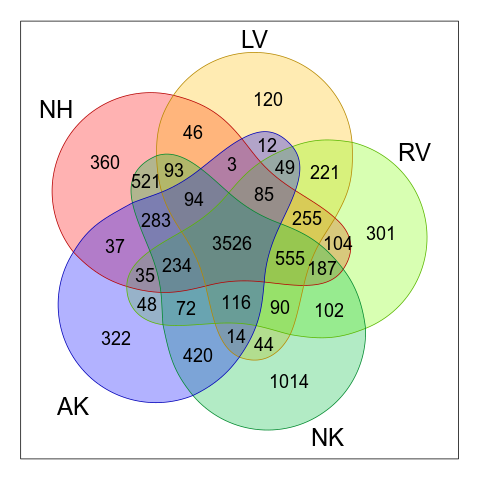

In [15]:
%%R 
# Venn for All Heart and Kidney samples; separate Left and Right
library(venn)
record = list(
    NH = unique(NH$gene),
    LV = unique(LV$gene),
    RV = unique(RV$gene),
    NK = unique(NK$gene),
    AK = unique(AK$gene)
)
venn(record, ilab=T, zcolor='style', cexil=1.5, cexsn=2)
pdf('_data/methylated_genes.venn.pdf')
venn(record, ilab=T, zcolor='style', cexil=1.5, cexsn=2)
dev.off()

png 
  2 


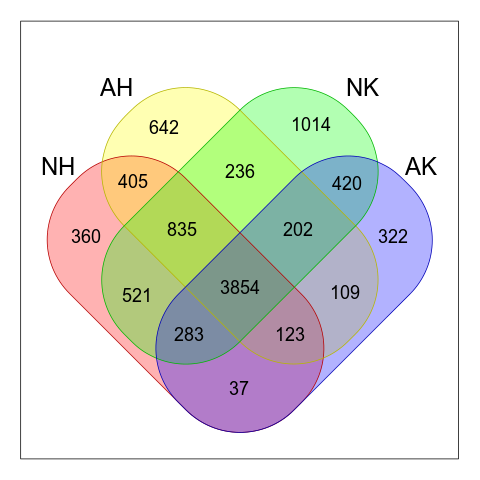

In [16]:
%%R 
# Venn for All Heart and Kidney samples; merge Left and Right as Adult
library(venn)
record = list(
    NH = unique(NH$gene),
    AH = unique(c(LV$gene, RV$gene)),
    NK = unique(NK$gene),
    AK = unique(AK$gene)
)
venn(record, ilab=T, zcolor='style', cexil=1.5, cexsn=2, ecllipse=T)
pdf('_data/methylated_genes.collapseLVRV.venn.pdf')
venn(record, ilab=T, zcolor='style', cexil=1.5, cexsn=2, ecllipse=T)
dev.off()

png 
  2 


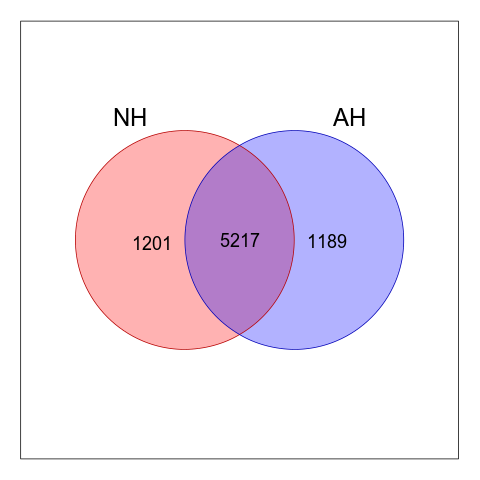

In [18]:
%%R 
# Venn for Only Heart samples; merge Left and Right
library(venn)
record = list(
    NH = unique(NH$gene),
    AH = unique(c(LV$gene, RV$gene))
)
venn(record, ilab=T, zcolor='style', cexil=1.5, cexsn=2, ecllipse=T)
pdf('_data/methylated_genes.Heart.venn.pdf')
venn(record, ilab=T, zcolor='style', cexil=1.5, cexsn=2, ecllipse=T)
dev.off()

png 
  2 


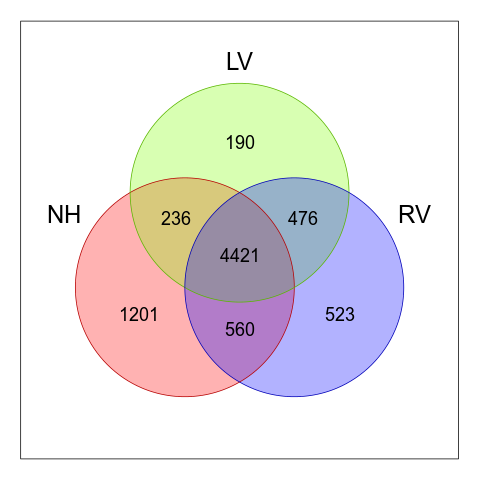

In [21]:
%%R 
# Venn for Only Heart samples; separate Left and Right
library(venn)
record = list(
    NH = unique(NH$gene),
    LV = unique(LV$gene), 
    RV = unique(RV$gene)
)
venn(record, ilab=T, zcolor='style', cexil=1.5, cexsn=2, ecllipse=T)
pdf('_data/methylated_genes.HeartLVRV.venn.pdf')
venn(record, ilab=T, zcolor='style', cexil=1.5, cexsn=2, ecllipse=T)
dev.off()

png 
  2 


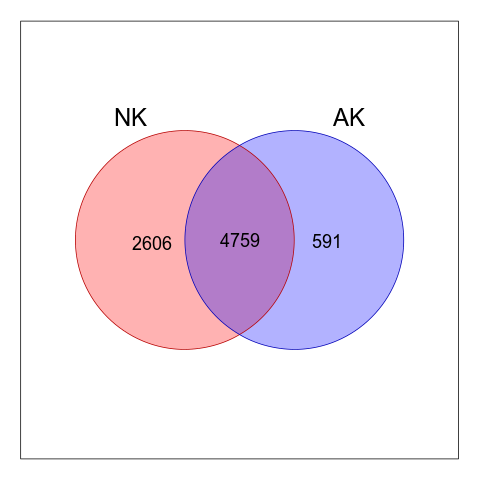

In [22]:
%%R 
# Venn for Only Heart samples; separate Left and Right
library(venn)
record = list(
    NK = unique(NK$gene),
    AK = unique(AK$gene) 
)
venn(record, ilab=T, zcolor='style', cexil=1.5, cexsn=2, ecllipse=T)
pdf('_data/methylated_genes.Kidney.venn.pdf')
venn(record, ilab=T, zcolor='style', cexil=1.5, cexsn=2, ecllipse=T)
dev.off()